# CONVOLUTIONAL NEURAL NETWORK APPLICATION

## Introduction

In this section, we will use the famous [MNIST Dataset](http://yann.lecun.com/exdb/mnist/) to build two Neural Networks capable to perform handwritten digits classification. The first Network is a simple Multi-layer Perceptron (MLP) and the second one is a Convolutional Neural Network (CNN). In other words, when given an input our algorithm will say, with some associated error, what type of digit this input represents.

<div class="alert alert-block alert-info">
<h2>Table of Contents</h2>
<ol>
    <li><a href="#ref1">What is Deep Learning</a></li>
    <li><a href="#ref2">Simple test: Is TensorFlow working?</a></li>
    <li><a href="#ref3">1st part: classify MNIST using a simple model</a></li>
    <li><a href="#ref4">Evaluating the final result</a></li>
    <li><a href="#ref5">How to improve our model?</a></li>
    <li><a href="#ref6">2nd part: Deep Learning applied on MNIST</a></li>
    <li><a href="#ref7">Summary of the Deep Convolutional Neural Network</a></li>
    <li><a href="#ref8">Define functions and train the model</a></li>
    <li><a href="#ref9">Evaluate the model</a></li>
</ol>    
</div>

<a id="ref1"></a>
<h2>What is Deep Learning?</h2>

<b>Brief Theory:</b> Deep learning (also known as deep structured learning, hierarchical learning or deep machine learning) is a branch of machine learning based on a set of algorithms that attempt to model high-level abstractions in data by using multiple processing layers, with complex structures or otherwise, composed of multiple non-linear transformations.

<img src="https://ibm.box.com/shared/static/gcbbrh440604cj2nksu3f44be87b8ank.png" alt="HTML5 Icon" style="width: 600px; height: 450px;">
<div style="text-align: center">It's time for deep learning. Our brain doesn't work with only one or three layers. Why it would be different with machines?. </div>

<b>In Practice, defining the term "Deep":</b> in this context, deep means that we are studying a Neural Network which has several hidden layers (more than one), no matter what type (convolutional, pooling, normalization, fully-connected etc). The most interesting part is that some papers noticed that Deep Neural Networks with the right architectures/hyper-parameters achieve better results than shallow Neural Networks with the same computational power (e.g. number of neurons or connections). 

<b>In Practice, defining "Learning":</b> In the context of supervised learning, digits recognition in our case, the learning part consists of a target/feature which is to be predicted using a given set of observations with the already known final prediction (label). In our case, the target will be the digit (0, 1, 2, 3, 4, 5, 6, 7, 8, 9) and the observations are the intensity and relative position of the pixels. After some training, it is possible to generate a "function" that map inputs (digit image) to desired outputs(type of digit). The only problem is how well this map operation occurs. While trying to generate this "function", the training process continues until the model achieves a desired level of accuracy on the training data.

In this tutorial, we first classify MNIST using a simple Multi-layer perceptron and then, in the second part, we use deeplearning to improve the accuracy of our results.

<a id="ref3"></a>
<h2>1st part: classify MNIST using a simple model.</h2>

We are going to create a simple Multi-layer perceptron, a simple type of Neural Network, to perform classification tasks on the MNIST digits dataset. If you are not familiar with the MNIST dataset, please consider to read more about it: <a href="http://yann.lecun.com/exdb/mnist/">click here</a> 

<h3>What is MNIST?</h3>

According to LeCun's website, the MNIST is a: "database of handwritten digits that has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image".

<h3>Import the MNIST dataset using TensorFlow built-in feature</h3>

It's very important to notice that MNIST is a high optimized data-set and it does not contain images. You will need to build your own code if you want to see the real digits. Another important side note is the effort that the authors invested on this data-set with normalization and centering operations.  

### Data Processing

In this part, we are going to see how we can read the mnist data from the original data source. Almost %80 of the AI work is usually processing the data as can be seen from this case also. We will read our data using numpy, convert labels to one-hot encoding, scale our data between 0-1, shuffle the data and retrieve batches repeatedly.  

In [1]:
import gzip
import tensorflow as tf
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
def read32(bytestream):
    return np.frombuffer(bytestream.read(4), 
                         dtype=np.dtype(np.uint32).newbyteorder('>'))[0]

**ONE-HOT ENCODING**

In [3]:
def one_hot(labels_dense, num_classes):
    """Convert class labels from scalars to one-hot vectors.
    Args:
        labels_dense: A numpy array containing image labels
        num_classes: Number of classes in the image
    Returns:
        labels_one_hot: A numpy array containing one-hot encoded data.
    """
    
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

**EXTRACT IMAGE DATA**

In [4]:
def extract_images(f):
    """Extract the images into a 4D uint8 numpy array [index, y, x, depth].
    Args:
        f: A file object that can be passed into a gzip reader.
    Returns:
        data: A 4D uint8 numpy array [index, y, x, depth].
    Raises:
        ValueError: If the bytestream does not start with 2051.
    """
    
    print('Extracting', f.name)
    
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = read32(bytestream)
        
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' % (magic, f.name))
        
        num_images = read32(bytestream)
        rows = read32(bytestream)
        cols = read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        
        return data

**EXTRACT LABELS**

In [5]:
def extract_labels(f, one_hot_encode=False, num_classes=10):
    """Extract the labels into a 1D uint8 numpy array [index].
    Args:
        f: A file object that can be passed into a gzip reader.
        one_hot_encode: Does one hot encoding for the result. Default False.
        num_classes: Number of classes for the one hot encoding.
    Returns:
        labels: a 1D uint8 numpy array.
    Raises:
        ValueError: If the bystream doesn't start with 2049.
    """
    
    print('Extracting', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = read32(bytestream)
        
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' % (magic, f.name))
            
        num_items = read32(bytestream)
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)
        
        if one_hot_encode:
            return one_hot(labels, num_classes)
        
        return labels

**A CONTAINER FOR OUR DATA INCLUDING BATCH FUNCTION**

In [6]:
class Dataset(object):

    def __init__(self, images, labels, one_hot=False, dtype=tf.float32, reshape=True, seed=None):
        """Construct a dataset given a image and its labels.   

        Args:
            images: Numpy image data.
            labels: Image labels
            one_hot: Indıcates one hot encoding for the data. Default is false
            dtype: Data type of our image.It can be either `uint8` to leave 
                   the input as `[0, 255]`, or `float32` to rescale into `[0, 1]`.
            reshape: Convert shape from [num examples, rows, columns, depth]
                     to [num examples, rows*columns] (assuming depth == 1)
            seed: Provides for convenient deterministic testing

        Returns:

        """

        seed1, seed2 = tf.random.get_seed(seed)

        # If op level seed is not set, use whatever graph level seed is returned
        np.random.seed(seed1 if seed is None else seed2)

        if dtype not in (tf.uint8, tf.float32):
            raise TypeError('Invalid image dtype %r, expected uint8 or float32' % dtype)

        assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
        
        self.num_examples = images.shape[0]
        
        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        if reshape:
            assert images.shape[3] == 1
            images = images.reshape(images.shape[0],
                                    images.shape[1] * images.shape[2])
        if dtype == tf.float32:
            # Convert from [0, 255] -> [0.0, 1.0].
            images = images.astype(np.float32)
            images = np.multiply(images, 1.0 / 255.0)
            
        self.features = images
        self.targets = labels
        self.epochs_completed = 0
        self.index_in_epoch = 0
        
    def next_batch(self, batch_size, shuffle=True):
        """Return the next `batch_size` examples from this data set."""
    
        start = self.index_in_epoch
        
        # Shuffle for the first epoch
        if self.epochs_completed == 0 and start == 0 and shuffle:
            perm0 = np.arange(self.num_examples)
            np.random.shuffle(perm0)
            self.features = self.features[perm0]
            self.targets = self.targets[perm0]

        # Go to the next epoch
        if start + batch_size > self.num_examples:
            # Finished epoch
            self.epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self.num_examples - start
            images_rest_part = self.features[start:self.num_examples]
            labels_rest_part = self.targets[start:self.num_examples]
          
            # Shuffle the data
            if shuffle:
                perm = np.arange(self.num_examples)
                np.random.shuffle(perm)
                self.features = self.features[perm]
                self.targets = self.targets[perm]
                
            # Start next epoch
            start = 0
            self.index_in_epoch = batch_size - rest_num_examples
            end = self.index_in_epoch
            images_new_part = self.features[start:end]
            labels_new_part = self.targets[start:end]
            
            return np.concatenate((images_rest_part, images_new_part), 
                                  axis=0), np.concatenate((labels_rest_part, 
                                                           labels_new_part), axis=0)
        
        else:
            self.index_in_epoch += batch_size
            end = self.index_in_epoch
            
            return self.features[start:end], self.targets[start:end]

**READ MNIST DATA**

In [7]:
def read_raw_mnist(img_names, one_hot=False, dtype=tf.float32, val_size=5000, 
                   reshape=True, seed=None):
    """ Reads the original mnist data as in zipped format.
    
    Args:
        img_names: A dictionary containing names of the training and test images.
                   Dictionary keys should be 'train_images', 'train_labels', 
                   'test_images', 'test_labels'
        one_hot: Indicates whether labels should be converted to one-hot encoding.Default False
        dtype: Data type of images. Default to tf.float32
        reshape: Convert shape from [num examples, rows, columns, depth]
                 to [num examples, rows*columns] (assuming depth == 1). Default True
        val_size: Validation data size apart from test data
        
    Returns:
        Datasets as a namedtuple contains train, validation, test data.
    """
    TRAIN_IMAGES = img_names['train_images']
    TRAIN_LABELS = img_names['train_labels']
    TEST_IMAGES = img_names['test_images']
    TEST_LABELS = img_names['test_labels']

    with tf.gfile.Open(TRAIN_IMAGES, 'rb') as f:
        train_images = extract_images(f)

    with tf.gfile.Open(TRAIN_LABELS, 'rb') as f:
        train_labels = extract_labels(f, one_hot_encode=one_hot)

    with tf.gfile.Open(TEST_IMAGES, 'rb') as f:
        test_images = extract_images(f)

    with tf.gfile.Open(TEST_LABELS, 'rb') as f:
        test_labels = extract_labels(f, one_hot_encode=one_hot)


    val_images = train_images[:val_size]
    val_labels = train_labels[:val_size]
    train_images = train_images[val_size:]
    train_labels = train_labels[val_size:]

    kwargs = dict(dtype=dtype, reshape=reshape, seed=seed)
    
    train = Dataset(train_images, train_labels, **kwargs)
    val = Dataset(val_images, val_labels, **kwargs)
    test = Dataset(test_images, test_labels, **kwargs)
    
    Datasets = namedtuple('Datasets', ['train', 'val', 'test'])
    
    return Datasets(train=train, val=val, test=test)

In [8]:
TRAIN_IMAGES = 'MNIST_data/train-images-idx3-ubyte.gz'
TRAIN_LABELS = 'MNIST_data/train-labels-idx1-ubyte.gz'
TEST_IMAGES = 'MNIST_data/t10k-images-idx3-ubyte.gz'
TEST_LABELS = 'MNIST_data/t10k-labels-idx1-ubyte.gz'

img_data = {'train_images': TRAIN_IMAGES, 'train_labels': TRAIN_LABELS, 
            'test_images':TEST_IMAGES, 'test_labels': TEST_LABELS }

mnist = read_raw_mnist(img_data, one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The <span style="background-color:#dcdcdc"> one-hot = True</span> argument only means that, in contrast to Binary representation, the labels will be presented in a way that to represent a number N, the $N^{th}$ bit is 1 while the the other bits are 0. For example, five and zero in a binary code would be:

<pre>
Number representation:    0
Binary encoding:        [2^5]  [2^4]   [2^3]   [2^2]   [2^1]   [2^0]  
Array/vector:             0      0       0       0       0       0 

Number representation:    5
Binary encoding:        [2^5]  [2^4]   [2^3]   [2^2]   [2^1]   [2^0]  
Array/vector:             0      0       0       1       0       1  
</pre>

Using a different notation, the same digits using one-hot vector representation can be show as: 

<pre>
Number representation:    0
One-hot encoding:        [5]   [4]    [3]    [2]    [1]   [0]  
Array/vector:             0     0      0      0      0     1   

Number representation:    5
One-hot encoding:        [5]   [4]    [3]    [2]    [1]    [0]  
Array/vector:             1     0      0      0      0      0   
</pre>

The imported data can be divided as follow:

- Training (mnist.train) >>  Use the given dataset with inputs and related outputs for training of NN. In our case, if you give an image that you know that represents a "nine", this set will tell the neural network that we expect a "nine" as the output.  
        - 55,000 data points
        - mnist.train.features for inputs
        - mnist.train.targets for outputs
  
   
- Validation (mnist.val) >> The same as training, but now the data is used to generate model properties (classification error, for example) and from this, tune parameters like the optimal number of hidden units or determine a stopping point for the back-propagation algorithm  
        - 5,000 data points
        - mnist.val.features for inputs
        - mnist.val.targets for outputs
  
  
- Test (mnist.test) >> the model does not have access to this informations prior to the testing phase. It is used to evaluate the performance and accuracy of the model against "real life situations". No further optimization beyond this point.  
        - 10,000 data points
        - mnist.test.features for inputs
        - mnist.test.targets for outputs
  

### Using InteractiveSession

You have two basic options when using TensorFlow to run your code:

- [Build graphs and run session] Do all the set-up and THEN execute a session to evaluate tensors and run operations (ops) 
- [Interactive session] create your coding and run on the fly. 

For this first part, we will use the interactive session that is more suitable for environments like Jupyter notebooks.

In [9]:
sess = tf.InteractiveSession()

It is a best practice to create placeholders before variable assignments when using TensorFlow. Here we'll create placeholders for inputs ("Xs") and outputs ("Ys").   

<b>Placeholder 'X':</b> represents the "space" allocated input or the images. 
<ul>
    <li>Each input has 784 pixels distributed by a 28 width x 28 height matrix</li>   
    <li>The 'shape' argument defines the tensor size by its dimensions.</li>     
    <li>1st dimension = None. Indicates that the batch size, can be of any size.</li>     
    <li>2nd dimension = 784. Indicates the number of pixels on a single flattened MNIST image.</li>    
</ul>
    
<b>Placeholder 'Y':</b> represents the final output or the labels.
<ul>
    <li>10 possible classes (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)</li>  
    <li>The 'shape' argument defines the tensor size by its dimensions.</li>    
    <li>1st dimension = None. Indicates that the batch size, can be of any size.</li>     
    <li>2nd dimension = 10. Indicates the number of targets/outcomes</li>   
</ul>
<b>dtype for both placeholders:</b> if you not sure, use tf.float32. The limitation here is that the later presented softmax function only accepts float32 or float64 dtypes. For more dtypes, check TensorFlow's documentation <a href="https://www.tensorflow.org/api_docs/python/tf/DType">here</a>


In [10]:
num_classes = 10
num_pixels = 28*28
batches = 50
epochs = 1000

In [11]:
X = tf.placeholder(tf.float32, shape=[None, num_pixels])
y = tf.placeholder(tf.float32, shape=[None, num_classes])

Now we are going to create the weights and biases, for this purpose they will be used as arrays filled with zeros. The values that we choose here can be critical, but we'll cover a better way on the second part, instead of this type of initialization.

In [12]:
# Weight & Bias tensor
w = tf.Variable(tf.zeros([num_pixels, num_classes],tf.float32))
b = tf.Variable(tf.zeros([num_classes],tf.float32))

Before, we assigned the weights and biases but we did not initialize them with null values. For this reason, TensorFlow need to initialize the variables that you assign.  
Please notice that we're using this notation "sess.run" because we previously started an interactive session.

In [13]:
# run the op initialize_all_variables using an interactive session
sess.run(tf.global_variables_initializer())

The only difference for our next operation to the picture below is that we are using the mathematical convention for what is being executed in the illustration. The tf.matmul operation performs a matrix multiplication between x (inputs) and W (weights) and after the code add biases.


<img src="https://ibm.box.com/shared/static/88ksiymk1xkb10rgk0jwr3jw814jbfxo.png" alt="HTML5 Icon" style="width:400px;height:350px;"> 
<div style="text-align:center">Illustration showing how weights and biases are added to neurons/nodes. </div>

In [14]:
# mathematical operation to add weights and biases to the inputs
tf.matmul(X, w) + b

<tf.Tensor 'add:0' shape=(?, 10) dtype=float32>

### Softmax Regression

Softmax is an activation function that is normally used in classification problems. It generate the probabilities for the output. For example, our model will not be 100% sure that one digit is the number nine, instead, the answer will be a distribution of probabilities where, if the model is right, the nine number will have a larger probability than the other other digits.

For comparison, below is the one-hot vector for a nine digit label:

A machine does not have all this certainty, so we want to know what is the best guess, but we also want to understand how sure it was and what was the second better option. Below is an example of a hypothetical distribution for a nine digit:

In [15]:
Y = tf.nn.softmax(tf.matmul(X, w) + b)

Logistic function output is used for the classification between two target classes 0/1. Softmax function is generalized type of logistic function. That is, Softmax can output a multiclass categorical probability distribution.

It is a function that is used to minimize the difference between the right answers (labels) and estimated outputs by our Network.

In [16]:
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=Y)

This is the part where you configure the optimizer for your Neural Network. There are several optimizers available, in our case we will use Gradient Descent because it is a well established optimizer.

In [17]:
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

Train using minibatch Gradient Descent.

In practice, Batch Gradient Descent is not often used because is too computationally expensive. The good part about this method is that you have the true gradient, but with the expensive computing task of using the whole dataset in one time. Due to this problem, Neural Networks usually use minibatch to train.

In [18]:
#Load 50 training examples for each training iteration   
for i in range(epochs):
    batch = mnist.train.next_batch(batch_size=batches)
    train.run(feed_dict={X: batch[0], y: batch[1]})

<img src="https://www.katacoda.com/basiafusinska/courses/tensorflow-getting-started/tensorflow-mnist-beginner/assets/network.png" alt="HTML5 Icon" style="width:800px;height:350px;"> 
<div style="text-align:center">Our Model</div>

First, we want to compare which labels were predicted correctly by using `tf.argmax` function. `tf.equal` returns the list of booleans so by casting the values to float and then calculating the average we finally get the accuracy of the model.

In [19]:
is_correct = tf.equal(tf.argmax(Y, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
acc = accuracy.eval(feed_dict={X: mnist.test.features, y: mnist.test.targets}) * 100
print("The final accuracy for the simple ANN model is: {} % ".format(acc) )

sess.close()

The final accuracy for the simple ANN model is: 90.67999720573425 % 


## How to Improve Our Model

<h4>Several options as follow:</h4>
<ul>
    <li>Regularization of Neural Networks using DropConnect</li>
    <li>Multi-column Deep Neural Networks for Image Classification</li> 
    <li>APAC: Augmented Pattern Classification with Neural Networks</li>
    <li>Simple Deep Neural Network with Dropout</li>
</ul>
<h4>In the next part we are going to explore the option:</h4>
<ul>
    <li>Simple Deep Neural Network with Dropout (more than 1 hidden layer)</li>
</ul> 

## 2nd Part Deep Learning on MNIST

In the first part, we learned how to use a simple ANN to classify MNIST. Now we are going to expand our knowledge using a Deep Neural Network. 


Architecture of our network is:
    
- (Input) -> [batch_size, 28, 28, 1]  >> Apply 32 filter of [5x5]
- (Convolutional layer 1)  -> [batch_size, 28, 28, 32]
- (ReLU 1)  -> [?, 28, 28, 32]
- (Max pooling 1) -> [?, 14, 14, 32]
- (Convolutional layer 2)  -> [?, 14, 14, 64] 
- (ReLU 2)  -> [?, 14, 14, 64] 
- (Max pooling 2)  -> [?, 7, 7, 64] 
- [fully connected layer 3] -> [1x1024]
- [ReLU 3]  -> [1x1024]
- [Drop out]  -> [1x1024]
- [fully connected layer 4] -> [1x10]

<img src="https://www.katacoda.com/basiafusinska/courses/tensorflow-getting-started/tensorflow-mnist-expert/assets/convolution.png" alt="HTML5 Icon" style="width:800px;height:350px;"> 
<div style="text-align:center">Our Model</div>



The next cells will explore this new architecture. In this part, we are going to build our graph and visualize the whole architecture of the system so that we understand it very well. 

In [20]:
mnist = read_raw_mnist(img_data, one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [21]:
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
channels = 1
kernel_size = 5
epochs = 600
learning_rate = 1e-4

<h4>Converting images of the data set to tensors</h4>

The input image is 28 pixels by 28 pixels, 1 channel (grayscale). In this case, the first dimension is the <b>batch number</b> of the image, and can be of any size (so we set it to -1). The second and third dimensions are width and height, and the last one is the image channels.

In [22]:
tf.reset_default_graph()

In [23]:
with tf.name_scope('Inputs'):
    x = tf.placeholder(tf.float32, shape=[None, num_pixels], name='Features')
    y = tf.placeholder(tf.float32, shape=[None, num_classes], name='Labels')
    
with tf.name_scope('Reshape_Input'):    
    X = tf.reshape(x, [-1, width, height, channels], name='Reshaped_Features')  

<h3>Convolutional Layer 1</h3>

<h4>Defining kernel weight and bias</h4>

We define a kernel here. The size of the filter/kernel is 5x5;  Input channels is 1 (grayscale);  and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So, the output of convolution layer would be 28x28x32). In this step, we create a filter / kernel tensor of shape <code>[filter_height, filter_width, in_channels, out_channels]</code>

In [24]:
with tf.name_scope('Conv1_Weights'):
    w_conv1 = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, channels, 32], stddev=0.1), 
                          name='weights')
    b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]), name='biases') # need 32 biases for 32 outputs

<img src="https://ibm.box.com/shared/static/vn26neef1nnv2oxn5cb3uueowcawhkgb.png" style="width: 800px; height: 400px;" alt="HTML5 Icon" >

</h4>Convolve with weight tensor and add biases.</h4>

To create convolutional layer, we use <b>tf.nn.conv2d</b>. It computes a 2-D convolution given 4-D input and filter tensors.

Inputs:
- tensor of shape [batch, in_height, in_width, in_channels]. x of shape [batch_size, 28 ,28, 1]
- a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]. W is of size [5, 5, 1, 32]
- stride which is  [1, 1, 1, 1]. The convolutional layer, slides the "kernel window" across the input tensor. As the input tensor has 4 dimensions:  [batch, height, width, channels], then the convolution operates on a 2D window on the height and width dimensions. __strides__ determines how much the window shifts by in each of the dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we could set other values, e.g. [1, 2, 2, 1]
    
    
Process:
- Change the filter to a 2-D matrix with shape [5\*5\*1,32]
- Extracts image patches from the input tensor to form a *virtual* tensor of shape `[batch, 28, 28, 5*5*1]`.
- For each batch, right-multiplies the filter matrix and the image vector.

Output:
- A `Tensor` (a 2-D convolution) of size tf.Tensor 'add_7:0' shape=(?, 28, 28, 32)- Notice: the output of the first convolution layer is 32 [28x28] images. Here 32 is considered as volume/depth of the output image.

In [25]:
with tf.name_scope('Convolution_1'):
    conv1 = tf.nn.conv2d(X, w_conv1, strides=[1, 1, 1, 1], padding='SAME', name='Conv2D') + b_conv1

<img src="https://ibm.box.com/shared/static/iizf4ui4b2hh9wn86pplqxu27ykpqci9.png" style="width: 800px; height: 400px;" alt="HTML5 Icon" >


<h4>Apply the ReLU activation Function</h4>

In this step, we just go through all outputs convolution layer, <b>conv1</b>, and wherever a negative number occurs, we swap it out for a 0. It is called ReLU activation Function.<br> Let f(x) is a ReLU activation function $f(x) = max(0,x)$.

In [26]:
with tf.name_scope('Conv1_ReLU_Activation'):
    relu_conv1 = tf.nn.relu(conv1, name='ReLU')

<h4>Apply the max pooling</h4>

<b>max pooling</b> is a form of non-linear down-sampling. It partitions the input image into a set of rectangles and, and then find the maximum value for that region. 

Lets use <b>tf.nn.max_pool</b> function to perform max pooling. 
<b>Kernel size:</b> 2x2 (if the window is a 2x2 matrix, it would result in one output pixel)  
<b>Strides:</b> dictates the sliding behaviour of the kernel. In this case it will move 2 pixels everytime, thus not overlapping. The input is a matrix of size 28x28x32, and the output would be a matrix of size 14x14x32.

<img src="https://ibm.box.com/shared/static/kmaja90mn3aud9mro9cn8pbbg1h5pejy.png" alt="HTML5 Icon" style="width: 900px; height: 500px;"> 



In [27]:
with tf.name_scope('Conv1_Max_Pooling'):
    # Max Poll 2x2
    max_conv1 = tf.nn.max_pool(relu_conv1, ksize=[1, 2, 2, 1] , 
                               strides=[1, 2, 2, 1], padding='SAME', name='Max_Pool') 

Our First layer is now completed. Let's start building the second second layer.

<h3>Convolutional Layer 2</h3>

<h4>Weights and Biases of kernels</h4>

We apply the convolution again in this layer. Lets look at the second layer kernel:  
- Filter/kernel: 5x5 (25 pixels) 
- Input channels: 32 (from the 1st Conv layer, we had 32 feature maps) 
- 64 output feature maps  

<b>Notice:</b> here, the input image is [14x14x32], the filter is [5x5x32], we use 64 filters of size [5x5x32], and the output of the convolutional layer would be 64 convolved image, [14x14x64].

<b>Notice:</b> the convolution result of applying a filter of size [5x5x32] on image of size [14x14x32] is an image of size [14x14x1], that is, the convolution is functioning on volume.

In [28]:
# Init variables for convolution layer
with tf.name_scope('Conv2_Weights'):
    w_conv2 = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, 32, 64], stddev=0.1), name='weights')
    b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]), name='biases') #need 64 biases for 64 outputs

# Convolve image with weight tensor and add biases.
with tf.name_scope('Convolution_2'):
    conv2 = tf.nn.conv2d(max_conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME', name='Conv2D') + b_conv2
    
# Apply the ReLU activation Function
with tf.name_scope('Conv2_ReLU_Activation'):
    relu_conv2 = tf.nn.relu(conv2, name='ReLU')

# Apply the max pooling 2x2    
with tf.name_scope('Conv2_Max_Pooling'):
    max_conv2 = tf.nn.max_pool(relu_conv2, ksize=[1, 2, 2, 1], 
                               strides=[1, 2, 2, 1], padding='SAME', name='Max_Pool') 

Second layer completed. So, what is the output of the second layer, layer2?
- it is 64 matrix of [7x7]

<h3>Fully Connected Layer</h3>

You need a fully connected layer to use the Softmax and create the probabilities in the end. Fully connected layers take the high-level filtered images from previous layer, that is all 64 matrices, and convert them to a flat array.

So, each matrix [7x7] will be converted to a matrix of [49x1], and then all of the 64 matrix will be connected, which make an array of size [3136x1]. We will connect it into another layer of size [1024x1]. So, the weight between these 2 layers will be [3136x1024]


<img src="https://ibm.box.com/shared/static/pr9mnirmlrzm2bitf1d4jj389hyvv7ey.png" alt="HTML5 Icon" style="width: 800px; height: 400px;"> 


In [29]:
# Flattening Second Layer
with tf.name_scope('Flatten'):
    layer2_mat = tf.reshape(max_conv2, shape=[-1, 7 * 7 * 64], name='flatten')

# Weights and Biases between layer 2 and 3
# Composition of the feature map from the last layer (7x7) multiplied 
# by the number of feature maps (64); 1027 outputs to Softmax layer
with tf.name_scope('Flatten_Weights'):
    w_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1), name='weights')
    b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]), name='biases') # need 1024 biases for 1024 outputs

# Matrix Multiplication (applying weights and biases)
with tf.name_scope('Flatten_Matrix_Mul'):
    fcl = tf.matmul(layer2_mat, w_fc1, name='MatMul') + b_fc1

# Apply the ReLU activation Function
with tf.name_scope('Flatten_ReLU_Activation'):
    relu_fc1 = tf.nn.relu(fcl, name='ReLU')

Third layer completed

<h4>Dropout Layer, Optional phase for reducing overfitting</h4>

It is a phase where the network "forget" some features. At each training step in a mini-batch, some units get switched off randomly so that it will not interact with the network. That is, it weights cannot be updated, nor affect the learning of the other network nodes.  This can be very useful for very large neural networks to prevent overfitting.

In [30]:
with tf.name_scope('DropOut'):
    keep = tf.placeholder(tf.float32, name='Keep')
    drop = tf.nn.dropout(relu_fc1, keep, name='Drop')

<h4>Readout Layer (Softmax Layer)</h4>

Type: Softmax, Fully Connected Layer.

In [31]:
# Weights and Biases
# In last layer, CNN takes the high-level filtered images and translate 
# them into votes using softmax. Input channels: 1024 (neurons from the 3rd Layer); 10 output features
with tf.name_scope('Softmax_Weights'):
    w_fc2 = tf.Variable(tf.truncated_normal([1024, num_classes], stddev=0.1), name='weights') #1024 neurons
    # 10 possibilities for digits [0,1,2,3,4,5,6,7,8,9]
    b_fc2 = tf.Variable(tf.constant(0.1, shape=[num_classes]), name='biases') 

# Matrix Multiplication (applying weights and biases)
with tf.name_scope('Softmax_MatMul'):
    fc = tf.matmul(drop, w_fc2, name='MatMul') + b_fc2

# Apply the Softmax activation Function
# softmax allows us to interpret the outputs of fcl4 as probabilities.
# So, y_conv is a tensor of probabilities
with tf.name_scope('Softmax'):
    Y_CNN= tf.nn.softmax(fc, name='softmax')

<a id="ref7"></a>
<h2>Summary of the Deep Convolutional Neural Network</h2>

Now is time to remember the structure of  our network

#### 0) Input - MNIST dataset
#### 1) Convolutional and Max-Pooling
#### 2) Convolutional and Max-Pooling
#### 3) Fully Connected Layer
#### 4) Processing - Dropout
#### 5) Readout layer - Fully Connected
#### 6) Outputs - Classified digits

## Train the Neural Network

<h4>Define the loss function</h4>

We need to compare our output, layer4 tensor, with ground truth for all mini_batch. we can use <b>cross entropy</b> to see how bad our CNN is working - to measure the error at a softmax layer.

The following code shows an toy sample of cross-entropy for a mini-batch of size 2 which its items have been classified.

In [32]:
with tf.name_scope('Loss'):
    loss = tf.losses.softmax_cross_entropy(y, Y_CNN)

with tf.name_scope('Train'):
    train = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
with tf.name_scope('Accuracy'):
    is_true = tf.equal(tf.argmax(Y_CNN, 1), tf.argmax(y, 1), name='output')
    acc = tf.reduce_mean(tf.cast(is_true, tf.float32), name='accuracy')

In [35]:
# evaluate in batches to avoid out-of-memory issues
n_batches = mnist.test.features.shape[0] // 50  # Floor division
cumulative_accuracy = 0.0
sess = tf.Session()

sess.run(tf.global_variables_initializer())

# Graph data
writer = tf.summary.FileWriter('logs')
writer.add_graph(sess.graph)

for i in range(epochs):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_acc = sess.run(acc, feed_dict={x:batch[0], y: batch[1], keep: 1.0})
        print("Step %d, training accuracy %g" %(i, float(train_acc)))
    sess.run(train, feed_dict={x: batch[0], y: batch[1], keep: 0.5})

Step 0, training accuracy 0.02
Step 100, training accuracy 0.52
Step 200, training accuracy 0.46
Step 300, training accuracy 0.64
Step 400, training accuracy 0.84
Step 500, training accuracy 0.92


In [36]:
# Evaluate the Model
for index in range(n_batches):
    batch = mnist.test.next_batch(50)
    cumulative_accuracy += sess.run(acc, feed_dict={x: batch[0], y: batch[1], keep: 1.0})
print("test accuracy {}".format(cumulative_accuracy / n_batches))

test accuracy 0.8488999968767166


<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<font size = 3><strong><i>You can run this cell if you REALLY have time to wait, or you are running it using Cloud Power (<b>change the type of the cell to code</b>)</i></strong></font>

## Visualization

Let's take a look at all the filters(weights and biases) to see what our model does.

In [42]:
def get_activations(layer, stimuli):
    units = sess.run(layer, feed_dict={x:np.reshape(stimuli, [1,784], order='F'), keep:1.0})
    plot_nn_filter(units)

In [46]:
def plot_nn_filter(units):
    import math
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
    plt.tight_layout()

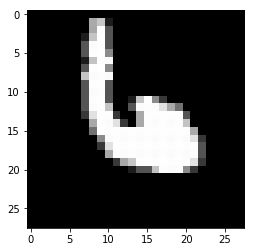

In [47]:
image = mnist.test.features[0]
plt.imshow(np.reshape(image, [height,width]), interpolation="nearest", cmap="gray")

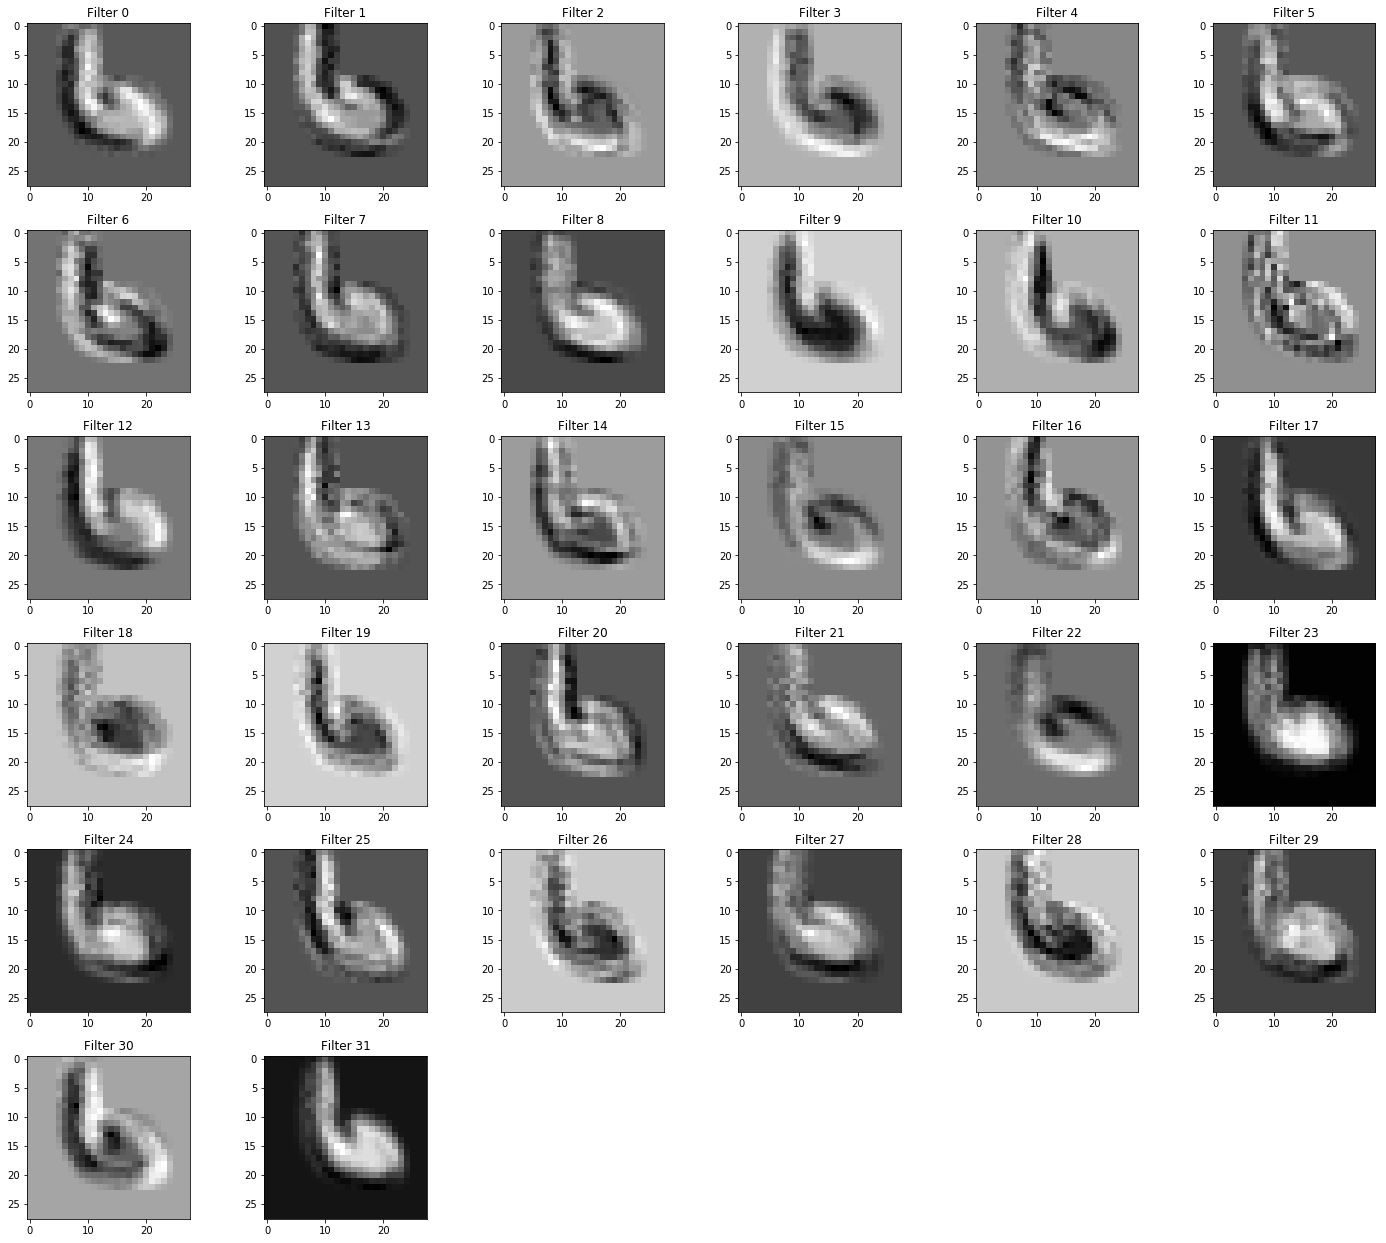

In [48]:
get_activations(conv1, image)

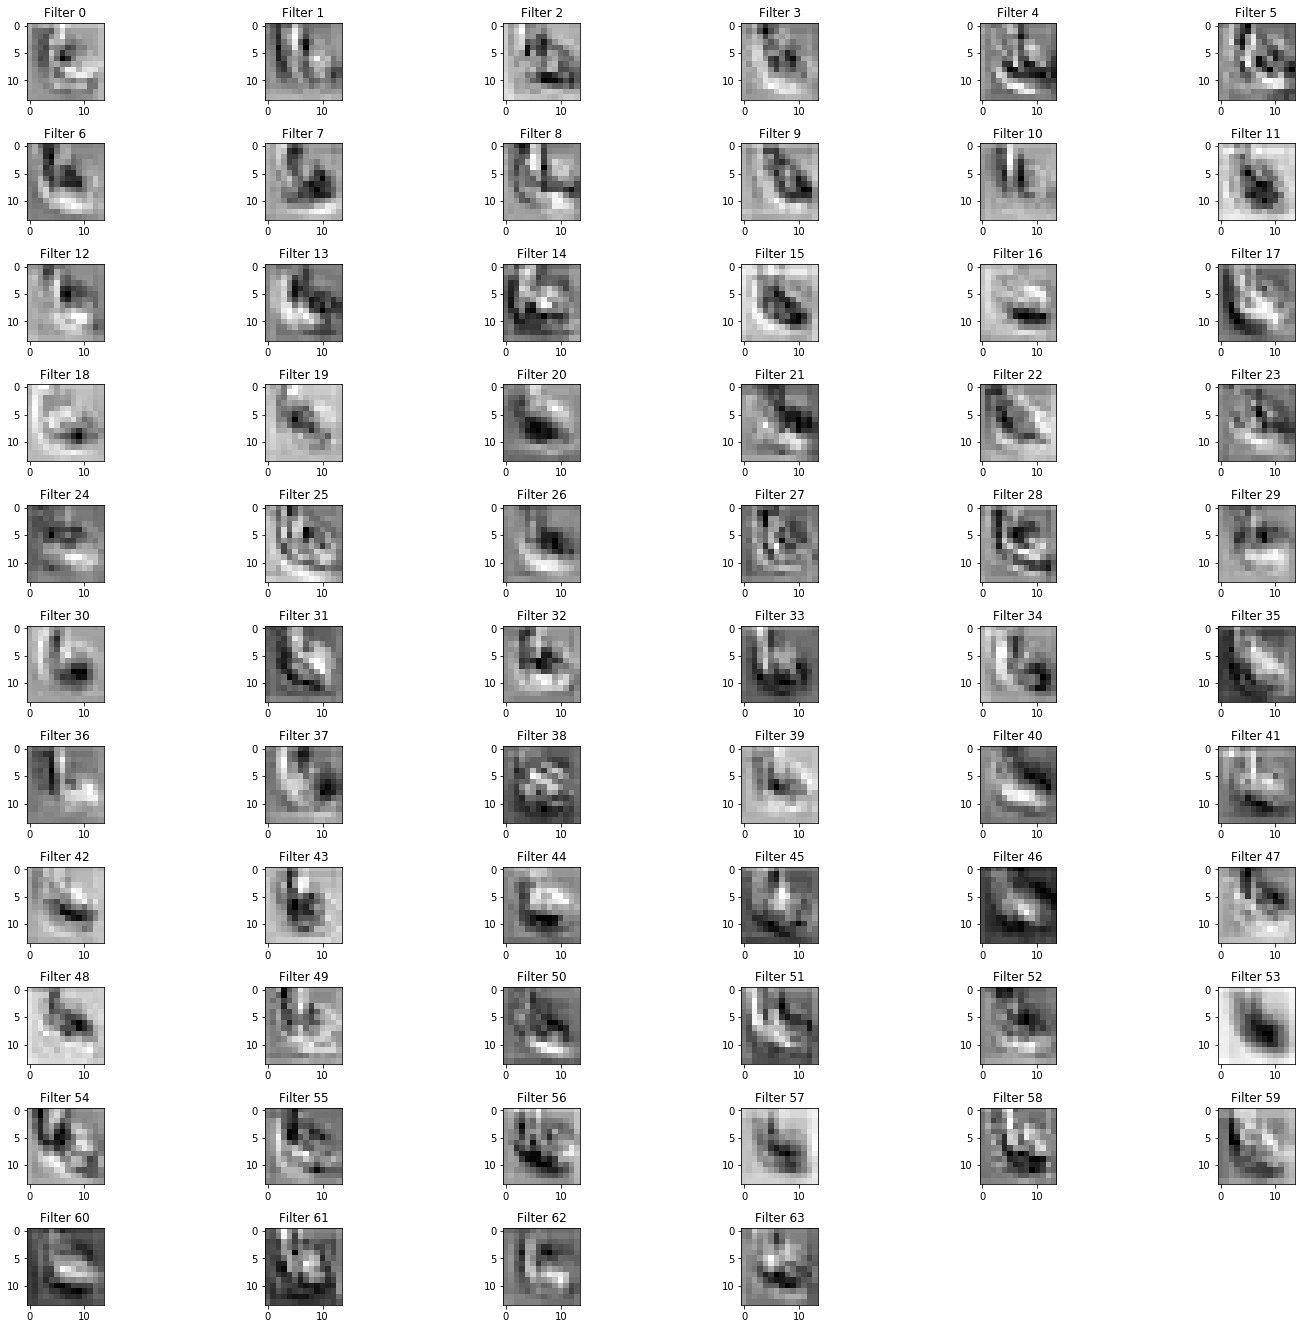

In [49]:
get_activations(conv2, image)

In [50]:
! tensorboard --logdir='logs/'

W0310 23:12:00.686528 Reloader tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0310 23:12:00.686528 139979553244928 tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0310 23:12:00.699619 Reloader tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0310 23:12:00.699619 139979553244928 tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
TensorBoard 1.12.2 at http://ai:6006 (Press CTRL+C to quit)
^C


## A Look to Our Graph

<a href="https://ibb.co/XxwcmHd"><img src="https://i.ibb.co/3mJgtK8/graph2.png" alt="graph2" border="0"></a><br />
